# Image Stitching (Python)

## Usage
This code snippet provides an overall code structure and some interactive plot interfaces for the Stitching Pairs of Images section of MP 3. In main function, we outline the required functionalities step by step. Feel free to make modifications on the starter code if it's necessary.

## Package installation
- `opencv`
- `numpy`
- `skimage`
- `scipy`

# Common imports

In [1]:
import numpy as np
import skimage
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import distance
import scipy
import skimage.io
import random
import skimage.transform
from PIL import Image


# Helper functions

In [2]:
def imread(fname):
    """
    read image into np array from file
    """
    return skimage.io.imread(fname)

def imread_bw(fname):
    """
    read image as gray scale format
    """
    return cv2.cvtColor(imread(fname), cv2.COLOR_BGR2GRAY)


def imshow(img):
    """
    show image
    """
    skimage.io.imshow(img)
    
def get_sift_data(img):
    """
    detect the keypoints and compute their SIFT descriptors with opencv library
    """
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    return kp, des

def plot_inlier_matches(ax, img1, img2, inliers):
    """
    plot the match between two image according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """

    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')
    
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2] + img1.shape[1], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2] + img1.shape[1]],
            [inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    ax.axis('off')
    

# Your implementations

In [3]:
def get_best_matches(img1, img2, num_matches):
    kp1, des1 = get_sift_data(img1)
    kp2, des2 = get_sift_data(img2)
    kp1, kp2 = np.array(kp1), np.array(kp2)
    
    # Find distance between descriptors in images
    dist = scipy.spatial.distance.cdist(des1, des2, 'sqeuclidean')
    
    # Write your code to get the matches according to dist
    # <YOUR CODE>

    idx1 = np.where(dist < num_matches)[0]
    idx2 = np.where(dist < num_matches)[1]
    c1 = []
    c2 = []
    for idx in idx1:
        c1.append(kp1[idx].pt)
    c1 = np.array(c1)
    
    for idx in idx2:
        c2.append(kp2[idx].pt)
    c2 = np.array(c2)

    # put into pairs of coords
    if len(c1) == 0 and len(c2) == 0:
        print("num_matches is too small")
        return []
    
    best_matches = np.concatenate((c1, c2), axis=1)

    return best_matches

In [4]:
def ransac(img1, img2, matches, thres_ransac):
    """
    write your ransac code to find the best model, inliers, and residuals
    """
    # <YOUR CODE>
    num_iterations = 10000
    inliners = 0
    max_inliers = 0

    for i in range(num_iterations):
        #In each iteration, I found 4 matchs and to calculate the homography of it.
        subset = matches[random.sample(range(matches.shape[0]), k=4)]
        H = compute_homography(subset)
        
#         If the rank of H is smaller than 3, continue to choose another 4 matchs. 
        if np.linalg.matrix_rank(H) < 3:
            continue

        #Then, we will get all inliers fitted the current model and the errors of each homography we have
        errors = get_errors(matches, H)
        idx = np.where(errors < thres_ransac)[0]
        inlinerspts = matches[idx]
        
        #Update the best model
        #We will find the best model by comparing the errro s. 
        #If total number of inliers  is larger than current one and the error 
        #is smaller than current one, we update the model.
        inliners = len(inlinerspts)
        if inliners >= max_inliers:
            which_inliners = inlinerspts.copy()
            max_inliers = inliners
            best_H = H.copy()
            #calculate the average residual
            avg_residual = sum(get_errors(matches[idx], H)) / inliners       

    return best_H, which_inliners, avg_residual, max_inliers


def get_errors(matches, H):
# The average residual for the inliers (mean squared
# distance between the point coordinates in one image and the transformed
# coordinates of the matching point in the other image)

    n = len(matches)

    p1 = np.concatenate((matches[:, 0:2], np.ones((1, n)).T), axis=1)
    p2 = matches[:, 2:4]

    transformed = np.zeros((n, 2))
    for i in range(n):
        transformed[i] = (np.dot(H, p1[i]) / np.dot(H, p1[i])[-1])[:2]

    errors = np.linalg.norm(p2 - transformed, axis=1) ** 2
    return errors



In [5]:
def compute_homography(subset):
    """
    write your code to compute homography according to the matches
    """
    
    PH = []

    for i in range(subset.shape[0]):
        p1 = np.append(subset[i][:2], 1)
        p2 = np.append(subset[i][2:], 1)
        
        row1 = [0, 0, 0, p1[0], p1[1], p1[2], -p2[1]*p1[0], -p2[1]*p1[1], -p2[1]*p1[2]]
        row2 = [p1[0], p1[1], p1[2], 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1], -p2[0]*p1[2]]
        PH.append(row1)
        PH.append(row2)

    PH = np.array(PH)
    
    #Find the SVD of A by the singular vector corresponding to the smallest singular value. 
    U, S, Vt = np.linalg.svd(PH)
    H = Vt[len(Vt)-1].reshape(3, 3)

    # normalize
    H = H / H[2, 2]
    return H

In [6]:
def warp_images(img0, img1, H, transform_right= False):
    """
    write your code to stitch images together according to the homography
    """
    #we we want to transform the right picture
    if transform_right:
        H = np.linalg.inv(H)
     
    #To find the transform from the best Homography results we got
    transform = skimage.transform.ProjectiveTransform(H)
    warp = skimage.transform.warp

    
    r, c, _ = img0.shape

    corners = np.array([[0, 0],[0, r],[c, 0],[c, r]])
    warped_corners = transform(corners)


    combine_corners = np.vstack((warped_corners, corners))
    
    # Create a new image big enough to hold the panorama by comparing 
    #the size of the pictures and get the min_corner and the max_corner for us. 
    #Then, we can calculate the output shape.
    min_corner = np.int32(combine_corners.min(axis=0))
    max_corner = np.int32(combine_corners.max(axis=0))
    
    output_shape = np.ceil((max_corner - min_corner)[::-1])

    offset = skimage.transform.SimilarityTransform(translation=-min_corner)
    
    img1_ = warp(img1, offset.inverse, output_shape=output_shape, cval=-1)
    img0_ = warp(img0, (transform + offset).inverse, output_shape=output_shape, cval=-1)
    img1_zeros = warp(img1, offset.inverse, output_shape=output_shape, cval=0)
    img0_zeros = warp(img0, (transform + offset).inverse, output_shape=output_shape, cval=0)
    
    #Compose the overlap part by calculating the averaging pixel of the two pictures. 
    img1_[img1_ != -1.0] = 1
    img1_[img1_ == -1.0] = 0
    img0_[img0_ != -1.0] = 1
    img0_[img0_ == -1.0] = 0
    overlap = img1_ + img0_
    overlap[overlap < 1] += 1
    
    im = (img1_zeros+img0_zeros)/overlap
    im = Image.fromarray((255*im).astype('uint8'), mode='RGB')
    im = np.asarray(im)

    return im

# Main functions

#### Load images

In [7]:
img1 = imread('./stitch/left.jpg')
img2 = imread('./stitch/right.jpg')

#### Part (3) compute and display the initial SIFT matching result

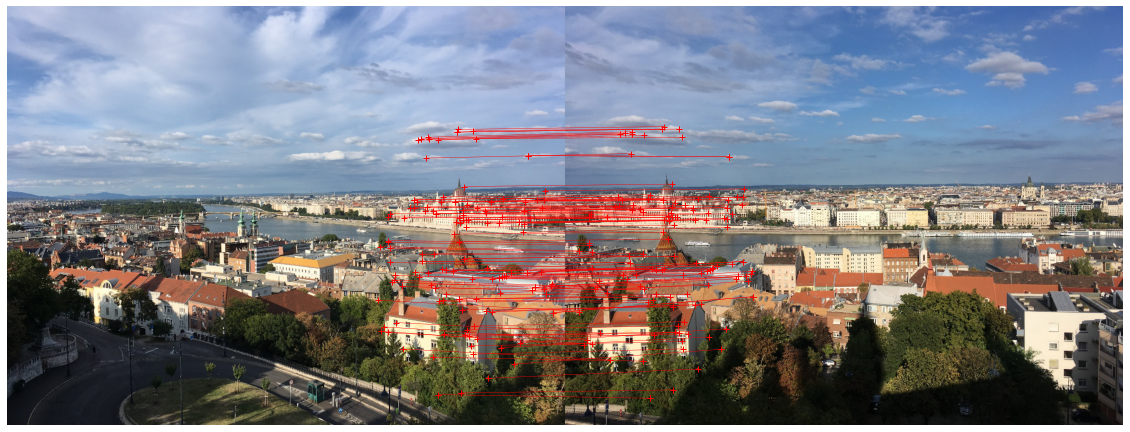

In [8]:
data = get_best_matches(img1, img2, 20000)
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, img1, img2, data)
fig.savefig('sift_match.pdf', bbox_inches='tight')

#### Part (4) performn RANSAC to get the homography and inliers

Average residual: 0.1000233935871485
Inliers: 111
best_H is : [[ 3.27128525e+00  8.86084032e-02 -2.17782960e+03]
 [ 7.49312204e-01  2.87107375e+00 -6.34010068e+02]
 [ 2.23000288e-03  5.50249000e-05  1.00000000e+00]]


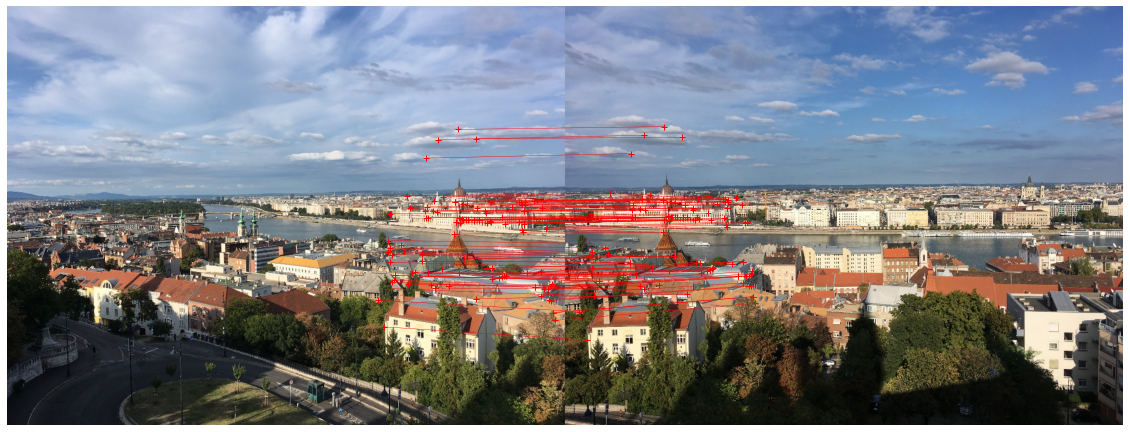

In [12]:
# display the inlier matching, report the average residual
# <YOUR CODE>
img1 = imread('./stitch/left.jpg')
img2 = imread('./stitch/right.jpg')
matches = get_best_matches(img1, img2, 20000)
best_H,data, avg_residual, max_inliers = ransac(img1, img2, matches, 0.3)
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, img1, img2, data)

print("Average residual:", avg_residual)
print("Inliers:", max_inliers)
print("best_H is :", best_H) 
fig.savefig('ransac_match.pdf', bbox_inches='tight')

#### Part (5) warp images to stitch them together

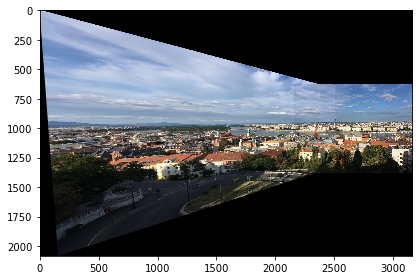

In [11]:
# display and report the stitching results
# <YOUR CODE>
img1 = imread('./stitch/left.jpg')
img2 = imread('./stitch/right.jpg')

stitched_img = warp_images(img1, img2, best_H)
fig.savefig('stitched_images.pdf', bbox_inches='tight')
cv2.imwrite('stitched_images.jpg', stitched_img[:,:,::-1]*255., [int(cv2.IMWRITE_JPEG_QUALITY), 90])
imshow(stitched_img)


#### Part (6) Extra credit:

In [7]:
img_op1_1 = imread('./extra_credits/opt_01/park_left.jpg')
img_op1_2 = imread('./extra_credits/opt_01/park_center.jpg')
img_op1_3 = imread('./extra_credits/opt_01/park_right.jpg')

In [8]:
# matches_op1_1 = get_best_matches(img_op1_1, img_op1_2, 10000)

In [9]:
# best_H_op1_1,_,_,_ = ransac(img_op1_1, img_op1_2, matches_op1_1, 0.3)


In [10]:
# stitched_img_op1_1_right = warp_images(img_op1_1, img_op1_2, best_H_op1_1)
# stitched_img_op1_1_left = warp_images(img_op1_1, img_op1_2, best_H_op1_1,  transform_right=False)

In [11]:
# imshow(stitched_img_op1_1_right)


In [12]:
# fig.savefig('stitched_img_op1_1_right.pdf', bbox_inches='tight')
# cv2.imwrite('stitched_img_op1_1_right.jpg', stitched_img_op1_1_right[:,:,::-1], [int(cv2.IMWRITE_JPEG_QUALITY), 90])

In [13]:
img_op1_4 = imread('stitched_img_op1_1_right.jpg')

In [14]:
matches_op1_2 = get_best_matches(img_op1_3, img_op1_4, 5000)

In [15]:
best_H_op1_2,_,_,_ = ransac(img_op1_3, img_op1_4, matches_op1_2, 0.3)

In [16]:
# inv_best_H_op1_2 = np.linalg.inv(best_H_op1_2)

In [ ]:
stitched_img_op1_1_final = warp_images(img_op1_3, img_op1_4, best_H_op1_2,transform_right= False)

In [ ]:
imshow(stitched_img_op1_1_final)

In [ ]:
cv2.imwrite('stitched_img_op1_1_final.jpg', stitched_img_op1_1_final[:,:,::-1], [int(cv2.IMWRITE_JPEG_QUALITY), 90])